In [1]:
import os
import time
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt
from model import SASRec
from utils import *
from accelerate import Accelerator

C:\Users\Hexiang\AppData\Roaming\Python\Python38\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Hexiang\AppData\Roaming\Python\Python38\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Hexiang\AppData\Roaming\Python\Python38\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
args = argparse.Namespace()
args.dataset = 'ml-1m-incremental'
args.train_dir='default'
args.batch_size = 128
args.one_batch = 1
args.lr = 0.0003
args.maxlen = 50
args.hidden_units = 50
args.num_blocks = 2
args.num_epochs = 201
args.num_heads = 1
args.dropout_rate = 0.5
args.l2_emb = 0.0
args.device = 'cuda'
args.inference_only = False
args.state_dict_path = 'Beauty_default/SASRec.epoch=201.lr=0.001.layer=2.head=1.hidden=50.maxlen=50.pth'
args.incremental_epochs = 5

args.kl_weight = 1
args.normal_loss_weight = 0.5

args.max_loss = 150
args.unlearning_rate = 0.005
args.max_steps = 500

In [3]:
def data_preparation(fgt_users, dataset):
    [user_train, user_valid, user_test, usernum, itemnum] = copy.deepcopy(dataset)
    fgt_dataset = [{}, {}, {}, 0 ,0]
    remain_dataset = [{}, {}, {}, 0 ,0]

    fgt_items = set()
    remain_items = set()
    for u in user_train.keys():
        if (u in fgt_users) and (u not in fgt_dataset[0].keys()):
            fgt_dataset[0][u] = user_train[u]
            fgt_dataset[1][u] = user_valid[u]
            fgt_dataset[2][u] = user_test[u]
            fgt_items.update(fgt_dataset[0][u])
        else:
            remain_dataset[0][u] = user_train[u]
            remain_dataset[1][u] = user_valid[u]
            remain_dataset[2][u] = user_test[u]
            remain_items.update(remain_dataset[0][u])

    fgt_dataset[3] = len(fgt_dataset[0].keys())
    fgt_dataset[4] = len(fgt_items)

    remain_dataset[3] = len(remain_dataset[0].keys())
    remain_dataset[4] = len(remain_items)

    cc = 0.0
    for u in dataset[0]:
        cc += len(dataset[0][u])
    print('average sequence length old_dataset: %.2f' % (cc / len(dataset[0])))

    cc = 0.0
    for u in fgt_dataset[0]:
        cc += len(fgt_dataset[0][u])
    print('average sequence length fgt_dataset: %.2f' % (cc / len(fgt_dataset[0])))

    cc = 0.0
    for u in remain_dataset[0]:
        cc += len(remain_dataset[0][u])
    print('average sequence length remain_dataset: %.2f' % (cc / len(remain_dataset[0])))

    return fgt_dataset, remain_dataset


In [4]:
def model_init(args, _dataset):
    dataset = copy.deepcopy(_dataset)
    model = SASRec(dataset[3], dataset[4], args).to(args.device) # no ReLU activation in original SASRec implementation?
    
    for name, param in model.named_parameters():
        try:
            torch.nn.init.xavier_normal_(param.data)
        except:
            pass # just ignore those failed init layers
    
    # this fails embedding init 'Embedding' object has no attribute 'dim'
    # model.apply(torch.nn.init.xavier_uniform_)
    
    model.train() # enable model training
    
    epoch_start_idx = 1
    if args.state_dict_path is not None:
        try:
            model.load_state_dict(torch.load(args.state_dict_path, map_location=torch.device(args.device)))
            tail = args.state_dict_path[args.state_dict_path.find('epoch=') + 6:]
            epoch_start_idx = int(tail[:tail.find('.')]) + 1
        except: # in case your pytorch version is not 1.6 etc., pls debug by pdb if load weights failed
            print('failed loading state_dicts, pls check file path: ', end="")
            print(args.state_dict_path)
            print('pdb enabled for your quick check, pls type exit() if you do not need it')
            import pdb; pdb.set_trace()
    
    return model

In [5]:
def evaluateeee(model, data, name):
    model.eval()
    t_test = evaluate(model, data, args)
    print(name + ' test (NDCG@10: %.4f, HR@10: %.4f)' % (t_test[0], t_test[1]))
    return

In [6]:
def evaluate_with_result(model, data):
    model.eval()
    t_test = evaluate(model, data, args)
    return t_test

In [7]:
def kl_loss(pretrained_model, current_model, sampler):
    """
    sampler = Norlmal Sampler
    """
    u, seq, pos, neg = sampler.next_batch() # tuples to ndarray
    u, seq, pos, neg = np.array(u), np.array(seq), np.array(pos), np.array(neg)
    cur_pos_logits, cur_neg_logits = current_model(u, seq, pos, neg)
    pre_pos_logits, pre_neg_logits = pretrained_model(u, seq, pos, neg)


    # P: pretrained model; Q: current model.
    prob_p = torch.nn.functional.softmax(pre_pos_logits, dim=-1)
    prob_q = torch.nn.functional.softmax(cur_pos_logits, dim=-1)

    log_prob_q = torch.log(prob_q + 1e-12)
    kl_loss = torch.nn.functional.kl_div(log_prob_q, prob_p, reduction='batchmean')
    
    return kl_loss

In [8]:
def normal_loss(current_model, sampler, optimizer, lossfunc):
    """
    sampler = Unlearning Sampler
    """
    u, seq, pos, neg = sampler.next_batch() # tuples to ndarray
    u, seq, pos, neg = np.array(u), np.array(seq), np.array(pos), np.array(neg)
    pos_logits, neg_logits = current_model(u, seq, pos, neg)
    pos_labels, neg_labels = torch.ones(pos_logits.shape, device=args.device), torch.zeros(neg_logits.shape, device=args.device)
    # print("\neye ball check raw_logits:"); print(pos_logits); print(neg_logits) # check pos_logits > 0, neg_logits < 0
    # optimizer.zero_grad()
    indices = np.where(pos != 0)
    loss = lossfunc(pos_logits[indices], pos_labels[indices])
    loss += lossfunc(neg_logits[indices], neg_labels[indices])

    return loss

In [9]:
def random_neq(l, r, s):  
    t = np.random.randint(l, r)
    while t in s:
        t = np.random.randint(l, r)
    return t

class tSimpleWarpSampler(object):
    def __init__(self, User, usernum, itemnum, batch_size=64, maxlen=10):
        self.User = User
        self.usernum = usernum
        self.itemnum = itemnum
        self.batch_size = batch_size
        self.maxlen = maxlen
        self.UserList = list(User.keys())

    def tsample(self):
        user = np.random.choice(self.UserList)
        while len(self.User[user]) <= 1: user = np.random.choice(self.UserList)
        
        seq = np.zeros([self.maxlen], dtype=np.int32)
        pos = np.zeros([self.maxlen], dtype=np.int32)
        neg = np.zeros([self.maxlen], dtype=np.int32)
        nxt = self.User[user][-1]
        idx = self.maxlen - 1

        ts = set(self.User[user])
        for i in reversed(self.User[user][:-1]):
            seq[idx] = i
            pos[idx] = nxt
            if nxt != 0: neg[idx] = random_neq(1, self.itemnum + 1, ts)
            nxt = i
            idx -= 1
            if idx == -1: break

        return (user, seq, pos, neg)

    def next_batch(self):
        one_batch = []
        for i in range(self.batch_size):
            one_batch.append(self.tsample())
        
        return zip(*one_batch)

def get_sampler(dataset, n_batch):
    [train, valid, test, usernum, itemnum] = dataset
    num_batch = len(train) // n_batch # tail? + ((len(user_train) % args.batch_size) != 0)
    sampler = tSimpleWarpSampler(train, usernum, itemnum, batch_size=args.batch_size, maxlen=args.maxlen)
    return num_batch, sampler

In [10]:
def unlearning(args, _unlerning_sampler, _remain_sampler, _pre_model, _cur_model, fgt):

    bce_criterion = torch.nn.BCEWithLogitsLoss() # torch.nn.BCELoss()
    adam_optimizer = torch.optim.Adam(_cur_model.parameters(), lr=args.unlearning_rate, betas=(0.9, 0.98))
    scheduler = torch.optim.lr_scheduler.StepLR(adam_optimizer, step_size=1, gamma=0.9)  # 逐步降低学习率

    his_fgt_losses = []
    his_remain_losses = []

    pre_normal_loss = 0.0
    move_step = 0

    # for epoch in range(epoch_start_idx, args.incremental_epochs + 1):
    
    while move_step < args.max_steps: # tqdm(range(num_batch), total=num_batch, ncols=70, leave=False, unit='b'):
        adam_optimizer.zero_grad()
        _kl_loss = kl_loss(_pre_model, _cur_model, _remain_sampler)
        _normal_loss = normal_loss(_cur_model, _unlerning_sampler, adam_optimizer, bce_criterion)
        loss = args.kl_weight * _kl_loss - args.normal_loss_weight * _normal_loss
        
        loss.backward()
        adam_optimizer.step()

        stop_button = False

        
        # 每一定步数检查一次模型在fgt和remain数据集上的损失
        fgt_loss = normal_loss(_cur_model, _unlerning_sampler, adam_optimizer, bce_criterion).item()
        remain_loss = normal_loss(_cur_model, _remain_sampler, adam_optimizer, bce_criterion).item()
        his_fgt_losses.append(fgt_loss)
        his_remain_losses.append(remain_loss)
        if move_step % 20 == 0:
            scheduler.step()
        if move_step % 50 == 0:
            evl_on_fgt = evaluate_with_result(_cur_model, fgt)
            
            # print(f"Step {move_step}, FGT Loss: {fgt_loss}, Remain Loss: {remain_loss}, Total Loss: {loss.item()}, NDCG@10: {evl_on_fgt[0]}, HR@10: {evl_on_fgt[1]}")
            print(f"Step {move_step}, FGT Loss: {fgt_loss:.4f}, Remain Loss: {remain_loss:.4f}, Total Loss: {loss:.4f}, NDCG@10: {evl_on_fgt[0]:.4f}, HR@10: {evl_on_fgt[1]:.4f}")
            # scheduler.step()
            # 检查是否满足停止条件
            if stop_button:
                if fgt_loss > args.max_loss or abs(pre_normal_loss - remain_loss) < 0.1:
                    print("Stopping criteria met. Ending unlearning.")
                    break
            
            adam_optimizer.zero_grad()
            # 根据需要调整学习率
            if not stop_button and evl_on_fgt[1] < 0.05:
                # scheduler.step()
                scheduler = torch.optim.lr_scheduler.StepLR(adam_optimizer, step_size=1, gamma=0.8)
                stop_button = True
        pre_normal_loss = remain_loss
        move_step += 1
        # print("loss in epoch {} iteration {}: {}".format(epoch_start_idx, move_step, loss.item())) # expected 0.4~0.6 after init few epochs
            
    # print("loss in step {}: {}".format(move_step, loss.item())) # expected 0.4~0.6 after init few epochs
    print("Done")
    return _pre_model, _cur_model, his_fgt_losses, his_remain_losses

## Preprocessing

In [11]:
old_dataset = data_partition('Beauty') # {train}, {valid}, {test}, usernum, itemnum

In [12]:
pre_model = model_init(args, old_dataset)
cur_model = model_init(args, old_dataset)
# cur_model.train()

## Unlearning

In [13]:
fgt_users = range(2600)
fgt_dataset, remain_dataset = data_preparation(fgt_users, old_dataset)
fgt_num_batch, fgt_sampler = get_sampler(fgt_dataset, args.one_batch)
remain_num_batch, remain_sampler = get_sampler(remain_dataset, args.batch_size)

average sequence length old_dataset: 5.63
average sequence length fgt_dataset: 11.05
average sequence length remain_dataset: 5.35


In [14]:
evaluateeee(cur_model, fgt_dataset, '\n cur_fgt ')
evaluateeee(cur_model, old_dataset, '\n cur_remain ')

.........................
 cur_fgt  test (NDCG@10: 0.2794, HR@10: 0.4537)
................................................................................................
 cur_remain  test (NDCG@10: 0.3008, HR@10: 0.4577)


In [15]:
pre_model, cur_model, fgt_losses, remain_losses = unlearning(args, fgt_sampler, remain_sampler, pre_model, cur_model, fgt_dataset)

.........................Step 0, FGT Loss: 0.2337, Remain Loss: 0.1805, Total Loss: 0.6841, NDCG@10: 0.2855, HR@10: 0.4595
.........................Step 50, FGT Loss: 8.7541, Remain Loss: 2.7044, Total Loss: -2.5946, NDCG@10: 0.1691, HR@10: 0.3066
.........................Step 100, FGT Loss: 12.1403, Remain Loss: 1.8258, Total Loss: -5.3257, NDCG@10: 0.1377, HR@10: 0.2590
.........................Step 150, FGT Loss: 15.8774, Remain Loss: 2.5988, Total Loss: -8.4899, NDCG@10: 0.1044, HR@10: 0.2149
.........................Step 200, FGT Loss: 18.2949, Remain Loss: 6.2516, Total Loss: -7.6666, NDCG@10: 0.0953, HR@10: 0.1978
.........................Step 250, FGT Loss: 22.9298, Remain Loss: 1.8017, Total Loss: -10.2901, NDCG@10: 0.0827, HR@10: 0.1723
.........................Step 300, FGT Loss: 24.6181, Remain Loss: 2.2067, Total Loss: -10.3286, NDCG@10: 0.0740, HR@10: 0.1595
.........................Step 350, FGT Loss: 25.0194, Remain Loss: 2.3628, Total Loss: -13.5352, NDCG@10: 0.0626, H

In [16]:

evaluateeee(cur_model, fgt_dataset, '\n cur_fgt ')
evaluateeee(cur_model, old_dataset, '\n cur_old ')
# evaluateeee(cur_model, remain_dataset, '\n cur_remain ')
# evaluateeee(pre_model, old_dataset, '\n pre_old ')
# evaluateeee(pre_model, fgt_dataset, '\n pre_fgt ')
# evaluateeee(pre_model, remain_dataset, '\n pre_remain ')

.........................
 cur_fgt  test (NDCG@10: 0.0568, HR@10: 0.1208)
................................................................................................
 cur_old  test (NDCG@10: 0.2504, HR@10: 0.4043)


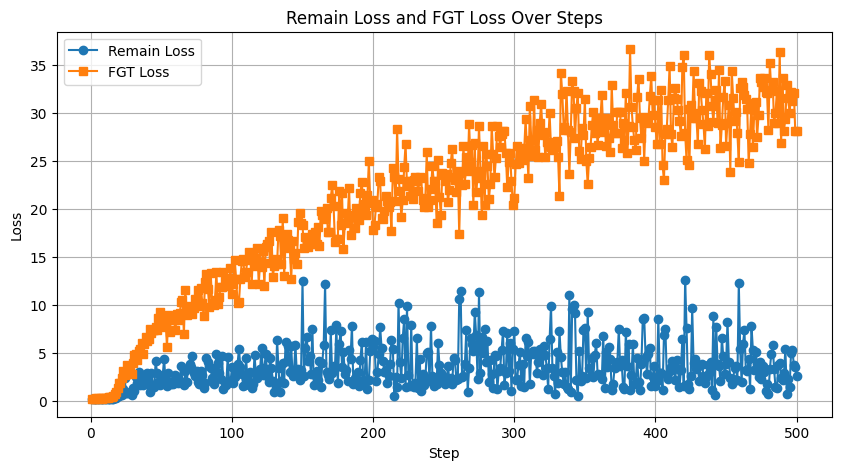

In [17]:
steps = list(range(1, len(remain_losses) + 1))

# 绘图
plt.figure(figsize=(10, 5))
plt.plot(steps, remain_losses, label='Remain Loss', marker='o')
plt.plot(steps, fgt_losses, label='FGT Loss', marker='s')

plt.title('Remain Loss and FGT Loss Over Steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
